In [95]:
import tensorflow as tf
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Input, Conv2D, multiply, LocallyConnected2D, Lambda, Flatten, concatenate
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.metrics import mean_absolute_error
from keras.applications import xception
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Import modules
import preprocessing as pp
import modeling as mod

import importlib
importlib.reload(pp)

<module 'preprocessing' from '/mnt/vstor/CSE_CSDS_VXC204/kjc131/BA-Model-2/preprocessing.py'>

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-06-09 16:15:13.824349: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2348] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 8.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [76]:
# Directories of images/data
train_path = '/mnt/vstor/CSE_CSDS_VXC204/kjc131/Full Cropped/train/'
train_out_path = './train/'
val_path = './validation/'
test_path = './test/'

# Load data
## All data
df_train, df_val, df_test = pp.prep_dfs()

In [77]:
## Sex-specific data
df_train_male, df_val_male, df_test_male, df_train_female, df_val_female, df_test_female = pp.prep_sex_dfs()


In [78]:

## All data
boneage_mean, boneage_std = mod.boneage_mean_std(df_train, df_val)

## Male
male_boneage_mean, male_boneage_std = mod.boneage_mean_std(df_train_male, df_val_male)

## Female
female_boneage_mean, female_boneage_std = mod.boneage_mean_std(df_train_female, df_val_female)


In [79]:
# Define parameters for models
pixels = 500
img_size = (pixels, pixels)
img_dims = (pixels, pixels, 3)
batch_size_train = 64
batch_size_val = 32
batch_size_test = len(df_test)
seed = 42
step_size_train = len(train_img_inputs)
step_size_val = len(val_img_inputs)

In [86]:
# Group bone age into categories for resampling
df_train['boneage_category'] = pd.cut(df_train['boneage'], 10)
train_df = df_train.groupby(['boneage_category', 'gender']).apply(lambda x: x.sample(500, replace=True)).reset_index(drop=True)
val_df = df_val

val_labels = val_df['boneage_zscore'].values


/tmp/job.2608346.hpc/ipykernel_2648555/2754610173.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train_df['boneage'], bins=10)


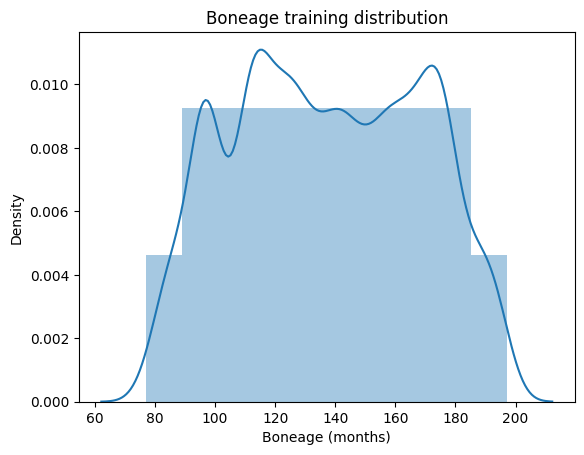

In [87]:
fig, ax = plt.subplots()
ax = sns.distplot(train_df['boneage'], bins=10)
ax.set(xlabel='Boneage (months)', ylabel='Density', title='Boneage training distribution');


In [104]:
# Calculate custom metrics
mae_months = pp.mae_months(y_true, y_pred, boneage_mean, boneage_std)
mae_months_male = pp.mae_months(y_true, y_pred, male_boneage_mean, male_boneage_std)
mae_months_female = pp.mae_months(y_true, y_pred, female_boneage_mean, female_boneage_std)

NameError: name 'y_true' is not defined

In [27]:
# Enhance contrast of images and save images
pp.enhance_img(train_path, train_out_path, df_train)

In [96]:
# Instantiate generators
train_idg = pp.idg(
    horizontal_flip = True,
    vertical_flip = False,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    rotation_range = 20,
    shear_range = 0.2,
    fill_mode = 'nearest',
    zoom_range = 0.2,
    )

test_idg = pp.idg()

# Generate inputs for images (single input, all data)
train_img_inputs = pp.gen_img_inputs(train_idg, df_train, train_path, batch_size_train, seed, True, 3, img_size)
val_img_inputs = pp.gen_img_inputs(test_idg, df_val, val_path, batch_size_val, seed, False, 3, img_size)
test_img_inputs = pp.gen_img_inputs(test_idg, df_test, test_path, batch_size_test, seed, False, 3, img_size)

# Generate inputs for images (single input, sex-specific data)
male_train_img_inputs = pp.gen_img_inputs(train_idg, df_train_male, train_path, batch_size_train, seed, True, 3, img_size)
male_val_img_inputs = pp.gen_img_inputs(test_idg, df_val_male, val_path, batch_size_val, seed, False, 3, img_size)
male_test_img_inputs = pp.gen_img_inputs(test_idg, df_test_male, test_path, batch_size_test, seed, False, 3, img_size)

female_train_img_inputs = pp.gen_img_inputs(train_idg, df_train_female, train_path, batch_size_train, seed, True, 3, img_size)
female_val_img_inputs = pp.gen_img_inputs(test_idg, df_val_female, val_path, batch_size_val, seed, False, 3, img_size)
female_test_img_inputs = pp.gen_img_inputs(test_idg, df_test_female, test_path, batch_size_test, seed, False, 3, img_size)

# Generate inputs for images & sex variables (two inputs)
train_img_sex_inputs = pp.gen_img_sex_inputs(train_idg, df_train, train_path, batch_size_train, seed, True, img_size)
val_img_sex_inputs = pp.gen_img_sex_inputs(test_idg, df_val, val_path, batch_size_val, seed, False, img_size)
test_img_sex_inputs = pp.gen_img_sex_inputs(test_idg, df_test, test_path, batch_size_test, seed, False, img_size)
    

Found 6418 validated image filenames.
Found 902 validated image filenames.
Found 703 validated image filenames.
Found 3177 validated image filenames.
Found 447 validated image filenames.
Found 344 validated image filenames.
Found 3241 validated image filenames.
Found 455 validated image filenames.
Found 359 validated image filenames.


In [108]:
# Instantiate optimizer
optim = mod.optimizer(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=0.0000001, decay=0)

In [109]:
# Instantiate callbacks
callbacks = mod.callbacks(factor=0.8, patience=5, min_lr=1e-6)

In [110]:
# Build & compile model
baseline_model = mod.baseline_model(img_dims, tf.keras.activations.tanh, optim, ["mae"])
baseline_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_20 (Dropout)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 500)               1024500   
                                                                 
 dropout_21 (Dropout)        (None, 500)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 501       
                                                     

In [63]:
print(val_df['boneage_zscore'].isna().sum())      # NaNs?
print(np.isinf(val_df['boneage_zscore']).sum())   # Infs?
print(val_df['boneage_zscore'].describe())        # Any weird outliers?

1
0
count    901.000000
mean       0.008314
std        1.001126
min       -2.546654
25%       -0.804508
50%        0.083269
75%        0.840717
max        1.647802
Name: boneage_zscore, dtype: float64


In [64]:
baseline_model.evaluate(val_img_inputs, steps=5)

5/5 [==============================] - 2s 199ms/step - loss: 0.9361 - mae: 0.9361


[0.9360588788986206, 0.9360588788986206]

In [65]:
# Batch-wise monitoring - no issues

for i, (x_batch, y_batch) in enumerate(val_img_inputs):
    preds = baseline_model.predict(x_batch)
    loss = tf.keras.losses.mean_absolute_error(y_batch, preds)
    print(f"Batch {i}  loss: {tf.reduce_mean(loss).numpy():.4f}")
    
    if i >= 4:  # limit to 5 batches for now
        break


1/1 [==============================] - 1s 654ms/step
Batch 0  loss: 0.9598
1/1 [==============================] - 0s 98ms/step
Batch 1  loss: 0.7804
1/1 [==============================] - 0s 102ms/step
Batch 2  loss: 0.8784
1/1 [==============================] - 0s 97ms/step
Batch 3  loss: 0.9519
1/1 [==============================] - 0s 105ms/step
Batch 4  loss: 1.0192


In [107]:
# Train model with convolutional base frozen initially
baseline_history1 = baseline_model.fit(
    train_img_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_inputs,
    validation_steps = step_size_val,
    epochs = 5,
    callbacks = callbacks
    )

29/29 [==============================] - 6s 166ms/step - loss: nan - mae: nan
Epoch 1/5


KeyboardInterrupt: 

In [13]:
# Fine-tune: unfreeze last 2 convolutional blocks of base model & re-train these layers along with additional networks
# Lower learning rate
baseline_model = mod.fine_tune(model=baseline_model, lr=0.0001, metric=["mae"])

# Re-train model
baseline_history2 = baseline_model.fit(
    train_img_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_inputs,
    validation_steps = step_size_val,
    epochs = 5,
    callbacks = callbacks
    )
     

Epoch 1/5
100/100 [==============================] - 271s 3s/step - loss: 0.6226 - mae: 0.6226 - val_loss: nan - val_mae: nan - lr: 1.0000e-04
Epoch 2/5
 28/100 [=======>......................] - ETA: 3:05 - loss: 0.6265 - mae: 0.6265

KeyboardInterrupt: 

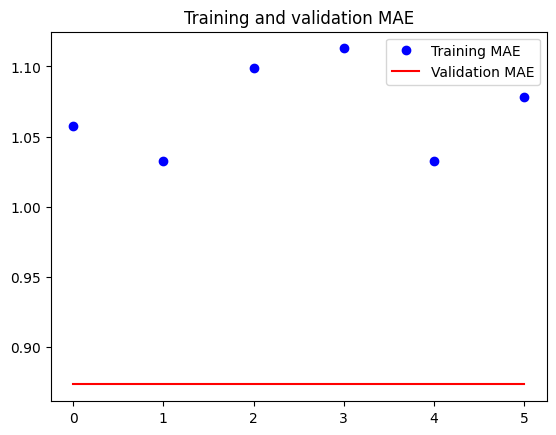

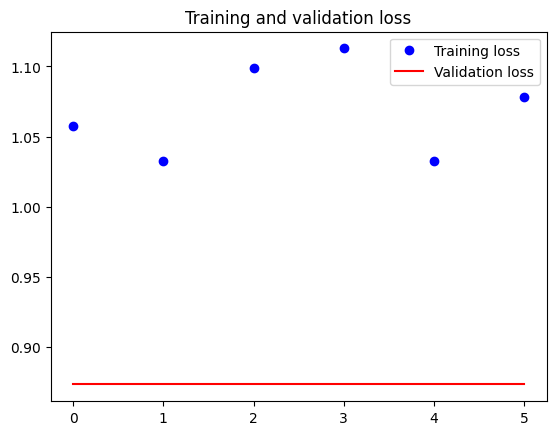

In [26]:
# Plot training history
mod.plot_history(baseline_history2)
baseline_model.save("no_attn_model.h5", overwrite=True, save_format="h5")

In [14]:
# Build & compile model
male_model = mod.baseline_model(img_dims, tf.keras.activations.tanh, optim, ["mae"])
male_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               1024500   
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                      

In [16]:
# Train model - MALE
history_male = male_model.fit(
    male_train_img_inputs,
    validation_data = male_val_img_inputs,
    epochs = 20,
    callbacks = callbacks
    )
     

Epoch 1/20
50/50 [==============================] - 135s 3s/step - loss: 0.5867 - mae: 0.5867 - val_loss: 0.4157 - val_mae: 0.4157 - lr: 1.0000e-04
Epoch 2/20
50/50 [==============================] - 135s 3s/step - loss: 0.5615 - mae: 0.5615 - val_loss: 0.4079 - val_mae: 0.4079 - lr: 1.0000e-04
Epoch 3/20
50/50 [==============================] - 135s 3s/step - loss: 0.5463 - mae: 0.5463 - val_loss: 0.4094 - val_mae: 0.4094 - lr: 1.0000e-04
Epoch 4/20
50/50 [==============================] - 134s 3s/step - loss: 0.5368 - mae: 0.5368 - val_loss: 0.3944 - val_mae: 0.3944 - lr: 1.0000e-04
Epoch 5/20
50/50 [==============================] - 135s 3s/step - loss: 0.5378 - mae: 0.5378 - val_loss: 0.3866 - val_mae: 0.3866 - lr: 1.0000e-04
Epoch 6/20
50/50 [==============================] - 134s 3s/step - loss: 0.5205 - mae: 0.5205 - val_loss: 0.3909 - val_mae: 0.3909 - lr: 1.0000e-04
Epoch 7/20
50/50 [==============================] - 134s 3s/step - loss: 0.5232 - mae: 0.5232 - val_loss: 0.4254

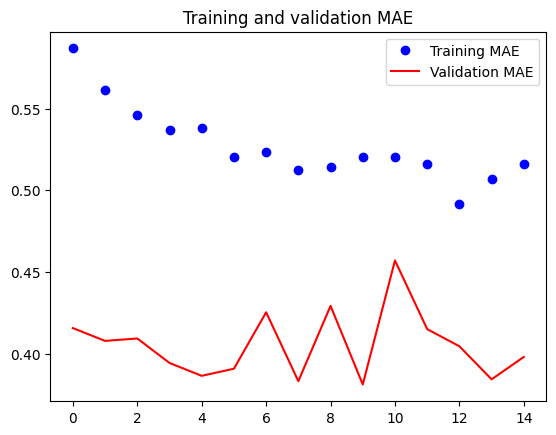

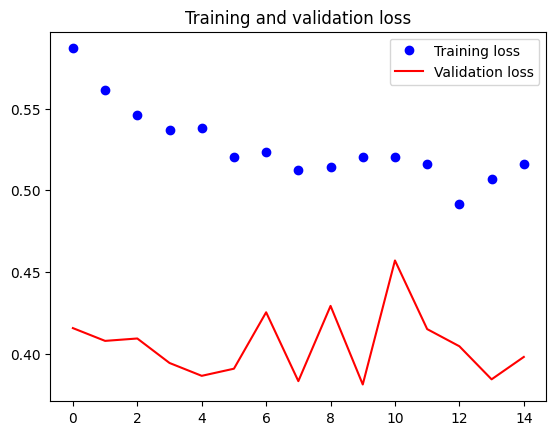

In [17]:
mod.plot_history(history_male)
male_model.save("male_simple.h5", overwrite=True, save_format="h5")

In [18]:

# Build & compile model
female_model = mod.baseline_model(img_dims, tf.keras.activations.tanh, optim, ["mae"])
female_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 16, 16, 2048)      20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 500)               1024500   
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                      

In [19]:
# Train model - MALE
history_female = female_model.fit(
    female_train_img_inputs,
    validation_data = female_val_img_inputs,
    epochs = 20,
    callbacks = callbacks
    )
     

Epoch 1/20
51/51 [==============================] - 144s 3s/step - loss: 0.6551 - mae: 0.6551 - val_loss: nan - val_mae: nan - lr: 8.0000e-05
Epoch 2/20
51/51 [==============================] - 139s 3s/step - loss: 0.5891 - mae: 0.5891 - val_loss: nan - val_mae: nan - lr: 8.0000e-05
Epoch 3/20
47/51 [==========================>...] - ETA: 10s - loss: 0.5340 - mae: 0.5340

KeyboardInterrupt: 

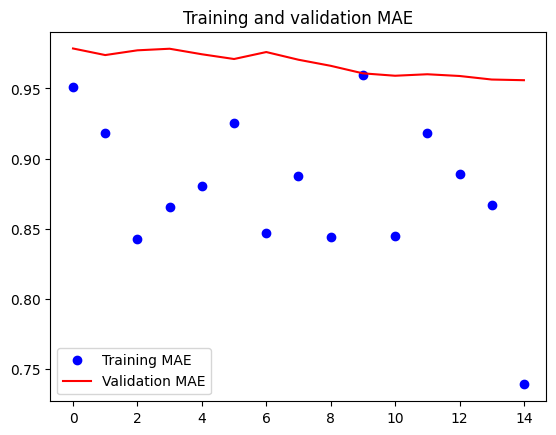

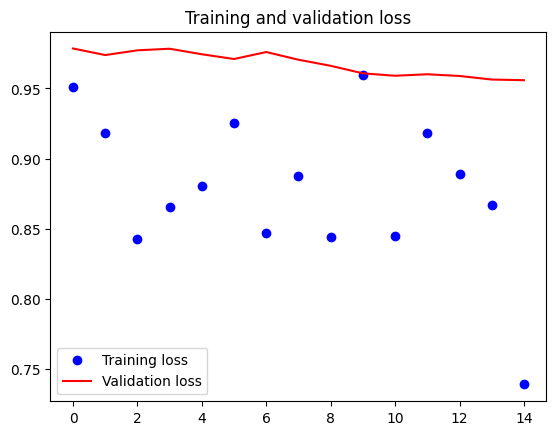

In [34]:
mod.plot_history(history_female)
female_model.save("female_simple.h5", overwrite=True, save_format="h5")

In [20]:
# Build & compile model
attn_model = mod.attn_model(img_dims, optim, ["mae"])
attn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 16, 16, 2048  20861480    ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 16, 16, 2048  8192       ['xception[0][0]']               
 ormalization)                  )                                                             

In [21]:
# Train model with convolutional base frozen
attn_history1 = attn_model.fit(
    train_img_inputs,
    steps_per_epoch = step_size_train,
    validation_data=val_img_inputs,
    validation_steps=step_size_val,
    epochs=5,
    callbacks=callbacks
    )

Epoch 1/5
 23/100 [=====>........................] - ETA: 3:21 - loss: 1.5266 - mae: 1.5266

KeyboardInterrupt: 

In [37]:
# Fine-tune
attn_model = mod.fine_tune(model=attn_model, lr=0.0001, metric=["mae"])

# Re-train model
attn_history2 = attn_model.fit(
    train_img_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_inputs,
    validation_steps = step_size_val,
    epochs = 20,
    callbacks = callbacks
    )

Epoch 1/20
45/45 [==============================] - 14s 85ms/step - loss: 5.0512 - mae: 5.0512 - val_loss: 1.7159 - val_mae: 1.7159 - lr: 1.0000e-04
Epoch 2/20
45/45 [==============================] - 1s 28ms/step - loss: 3.0342 - mae: 3.0342 - val_loss: 1.7159 - val_mae: 1.7159 - lr: 1.0000e-04
Epoch 3/20
45/45 [==============================] - 1s 28ms/step - loss: 2.5571 - mae: 2.5571 - val_loss: 1.7159 - val_mae: 1.7159 - lr: 1.0000e-04
Epoch 4/20
45/45 [==============================] - 1s 28ms/step - loss: 4.1477 - mae: 4.1477 - val_loss: 1.7159 - val_mae: 1.7159 - lr: 1.0000e-04
Epoch 5/20
45/45 [==============================] - 1s 28ms/step - loss: 2.4852 - mae: 2.4852 - val_loss: 1.7159 - val_mae: 1.7159 - lr: 1.0000e-04
Epoch 6/20
43/45 [===========================>..] - ETA: 0s - loss: 3.2154 - mae: 3.2154
Epoch 00006: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
45/45 [==============================] - 1s 28ms/step - loss: 3.1016 - mae: 3.1016 - val_l

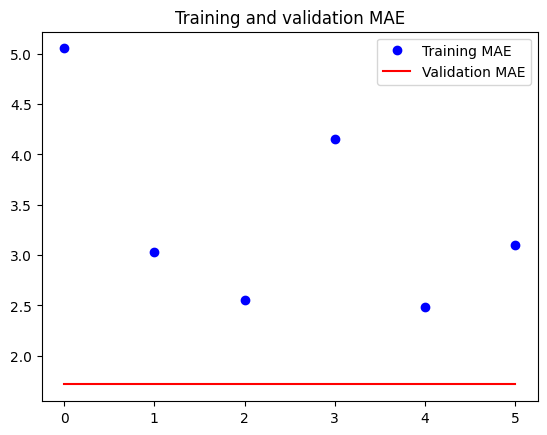

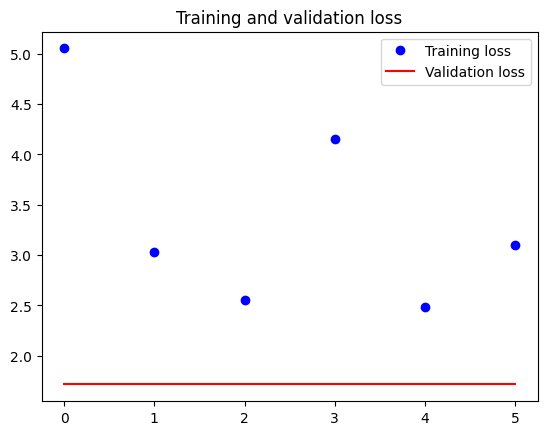

In [38]:
mod.plot_history(attn_history2)
attn_model.save("attn_model.h5", overwrite=True, save_format="h5")

In [12]:
# Build & compile model
sex_model = mod.sex_model(img_dims, optim, ["mae"])
sex_model.summary()

2024-09-30 05:10:53.863408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 05:10:54.178275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31139 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 xception (Functional)          (None, 16, 16, 2048  20861480    ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['xception[0][0]']               
 alAveragePooling2D)                                                                          

In [13]:
# Train model with convolutional base frozen
sex_history1 = sex_model.fit(
    train_img_sex_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_sex_inputs,
    validation_steps = step_size_val,
    epochs = 5,
    callbacks = callbacks
    )
     

Found 6418 validated image filenames.
Found 6418 validated image filenames.
Epoch 1/5


2024-09-30 05:11:24.471182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


100/100 [==============================] - ETA: 0s - loss: 0.6506 - mae: 0.6506Found 902 validated image filenames.
Found 902 validated image filenames.
100/100 [==============================] - 603s 6s/step - loss: 0.6506 - mae: 0.6506 - val_loss: nan - val_mae: nan - lr: 1.0000e-04
Epoch 2/5
100/100 [==============================] - 553s 6s/step - loss: 0.5063 - mae: 0.5063 - val_loss: nan - val_mae: nan - lr: 1.0000e-04
Epoch 3/5
100/100 [==============================] - 553s 6s/step - loss: 0.4774 - mae: 0.4774 - val_loss: nan - val_mae: nan - lr: 1.0000e-04
Epoch 4/5
100/100 [==============================] - 555s 6s/step - loss: 0.4431 - mae: 0.4431 - val_loss: nan - val_mae: nan - lr: 1.0000e-04
Epoch 5/5
100/100 [==============================] - ETA: 0s - loss: 0.4251 - mae: 0.4251
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
100/100 [==============================] - 556s 6s/step - loss: 0.4251 - mae: 0.4251 - val_loss: nan - val_mae: nan - l

In [14]:
# Fine-tune
sex_model = mod.fine_tune(model=sex_model, lr=0.0001, metric=["mae"])

# Re-train model
sex_history2 = sex_model.fit(
    train_img_sex_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_sex_inputs,
    validation_steps = step_size_val,
    epochs = 10,
    callbacks = callbacks
    )

Epoch 1/10
100/100 [==============================] - 562s 6s/step - loss: 0.4210 - mae: 0.4210 - val_loss: nan - val_mae: nan - lr: 1.0000e-04
Epoch 2/10
100/100 [==============================] - 558s 6s/step - loss: 0.4191 - mae: 0.4191 - val_loss: nan - val_mae: nan - lr: 1.0000e-04
Epoch 3/10
100/100 [==============================] - 557s 6s/step - loss: 0.4196 - mae: 0.4196 - val_loss: nan - val_mae: nan - lr: 1.0000e-04
Epoch 4/10
100/100 [==============================] - 557s 6s/step - loss: 0.4173 - mae: 0.4173 - val_loss: nan - val_mae: nan - lr: 1.0000e-04
Epoch 5/10
100/100 [==============================] - ETA: 0s - loss: 0.4108 - mae: 0.4108
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
100/100 [==============================] - 553s 6s/step - loss: 0.4108 - mae: 0.4108 - val_loss: nan - val_mae: nan - lr: 1.0000e-04
Epoch 5: early stopping


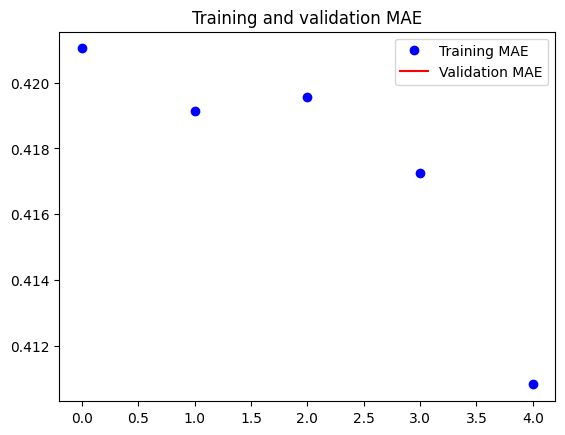

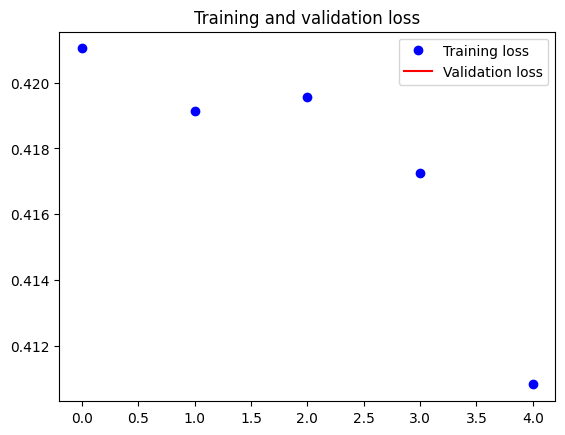

In [15]:
# Plot training history
mod.plot_history(sex_history2)
sex_model.save("sex_model.h5", overwrite=True, save_format="h5")

In [ ]:
# Build & compile model
attn_sex_model = mod.attn_sex_model(img_dims, optim, "mae")
attn_sex_model.summary()

In [ ]:
# Train model with convolutional base frozen
attn_sex_history1 = attn_sex_model.fit(
    train_img_sex_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_sex_inputs,
    validation_steps = step_size_val,
    epochs = 5,
    callbacks = callbacks
    )

In [ ]:
# Fine-tune
attn_model = mod.fine_tune(model=attn_sex_model, lr=0.0001, metric=["mae"])

# Re-train model
attn_sex_history2 = attn_sex_model.fit(
    train_img_sex_inputs,
    steps_per_epoch = step_size_train,
    validation_data = val_img_sex_inputs,
    validation_steps = step_size_val,
    epochs = 20,
    callbacks = callbacks
    )  

In [ ]:
# Plot training history
mod.plot_history(attn_sex_history2)
attn_sex_model.save("attn_sex_model.h5", overwrite=True, save_format="h5")

In [ ]:
# Build & compile model

# Load models
from keras.models import load_model
male_attn_model = load_model('attn_sex_model.h5', custom_objects={'mae':'mae'})

